# **Customer Support Sentiment Analysis**
- Code: [AndhikaWB](https://github.com/AndhikaWB/TweetCustServiceNLP)
- Dataset: [Kaggle](https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter)

### **Set Renderer**

In [1]:
import plotly.io as io

# Disable interactive visualization
print(io.renderers)
io.renderers.default = 'png'

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



### **Extract and Read Dataset**

In [2]:
import glob
import shutil
import zipfile
import os

# Combine multi-part zip files
with open('archive.zip', 'wb') as final_zip:
    for zip_part in glob.glob('archive.zip.*'):
        with open(zip_part, 'rb') as f:
            shutil.copyfileobj(f, final_zip)

# Extract the archive if it hasn't been extracted already
if not os.path.isfile('data/twcs.csv'):
    with zipfile.ZipFile('archive.zip') as zip:
        zip.extractall('data')

In [3]:
import pandas as pd

df = pd.read_csv('data/twcs.csv')
df

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


`inbound` here means whether it's directed to a company's customer support or not.

### **Data/Text Preprocessing**

#### **Data Type Correction**
For possible Exploratory Data Analysis (EDA) at the end
- String to datetime (`created_at`)
- String to integer array (`response_tweet_id`)
- Float to integer (other tweet IDs)

In [4]:
# Check data types and memory usage
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   tweet_id                 2811774 non-null  int64  
 1   author_id                2811774 non-null  object 
 2   inbound                  2811774 non-null  bool   
 3   created_at               2811774 non-null  object 
 4   text                     2811774 non-null  object 
 5   response_tweet_id        1771145 non-null  object 
 6   in_response_to_tweet_id  2017439 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


In [5]:
# Let's see why "response_tweet_id" is an object, not int/float
df[df['response_tweet_id'].notna() & df['response_tweet_id'].str.contains(',')].head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0
15,21,Ask_Spectrum,False,Tue Oct 31 22:14:37 +0000 2017,@115716 What information is incorrect? ^JK,"22,23",24.0
60,66,115728,True,Tue Oct 31 22:03:38 +0000 2017,@ChipotleTweets @28 \nI don't fit in my Veggie...,"64,67",NaN


It turns out that `response_tweet_id` is a list (array), so we need to parse it correctly before fixing the data type. However, note that the `response_tweet_id` value can also be nan (float).

In [6]:
import math
import numpy as np

def tweet_id_to_arr(value):
    # If empty/nan (aka the first tweet) then no need to make it as an array
    if type(value) == float and math.isnan(value): return pd.NA
    # Numpy's int array doesn't support nan, while Pandas' array does
    # However, converting to Pandas' array can be a lot slower
    return np.array(value.split(','), dtype = np.int64)

df['response_tweet_id'] = df['response_tweet_id'].apply(tweet_id_to_arr)

# https://strftime.org/
df['created_at'] = pd.to_datetime(df['created_at'], format = '%a %b %d %H:%M:%S %z %Y')

# Convert float to Pandas' Int64 (support nan)
# Pandas' Int64 array will use "pd.NA" rather than "np.nan"
# https://pandas.pydata.org/docs/user_guide/integer_na.html
cols = ['tweet_id', 'in_response_to_tweet_id']
df[cols] = df[cols].astype('Int64')

In [7]:
# Check whether Numpy's array and Pandas' array and use the same data type
print(type(df['response_tweet_id'].iloc[0][0])) # value row
print(type(df['response_tweet_id'].iloc[1])) # nan row

print(type(df['in_response_to_tweet_id'].iloc[0])) # value row
print(type(df['in_response_to_tweet_id'].iloc[6])) # nan row

<class 'numpy.int64'>
<class 'pandas._libs.missing.NAType'>
<class 'numpy.int64'>
<class 'pandas._libs.missing.NAType'>


In [8]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype              
---  ------                   --------------    -----              
 0   tweet_id                 2811774 non-null  Int64              
 1   author_id                2811774 non-null  object             
 2   inbound                  2811774 non-null  bool               
 3   created_at               2811774 non-null  datetime64[ns, UTC]
 4   text                     2811774 non-null  object             
 5   response_tweet_id        1771145 non-null  object             
 6   in_response_to_tweet_id  2017439 non-null  Int64              
dtypes: Int64(2), bool(1), datetime64[ns, UTC](1), object(3)
memory usage: 136.8+ MB


#### **Basic Text Preprocessing (1)**
Before moving on to sentiment analysis, we need to do some text preprocessing first. However, not everything has to be preprocessed/cleaned before doing the analysis. Some sentiment analysis libraries (e.g. [VADER](https://github.com/cjhutto/vaderSentiment)) are able to process raw text or even make a better prediction compared to cleaned text, so we only need to:
- Remove non-English tweets
- Remove URLs
- Remove HTML tags ([entities](https://www.w3schools.com/html/html_entities.asp) currently won't be checked, e.g. `%20`, `&nbsp`)
- Remove emails (must be prioritized before mentions)
- Remove mentions and hashtags
- Remove phone numbers (it's easier to just remove all numbers, but might mess with slang words or emoticons)
- Replace repeated characters (3 times+)
- Replace non-standard or multiple whitespaces (can be done last)

Depending on the libraries/algorithms, we may also need to do:
- Slang words and idioms conversion (to a more common words)
- Emojis and emoticons removal (or describe it as words)

**Note:** Be aware that some (if not most) sentiment analysis libraries are only able to score 1-gram word. [Splitting or describing](https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing) emojis/emoticons/slang as multiple words can also drastically [affect the score](https://medium.com/analytics-vidhya/sentiment-analysis-with-nltk-textblob-and-flair-a321d1460867) (e.g. "happy smile" will likely have more positive score than just "happy" or "smile").

See more info about VADER on the next section.

In [9]:
# fastText is a NLP library made by Facebook
# https://github.com/facebookresearch/fastText
import fasttext
# Regex
import re

# Suppress warning on fastText v0.9.2
fasttext.FastText.eprint = lambda x: None

# Predict language to remove non-English tweets
# https://fasttext.cc/docs/en/language-identification.html
lang_detector = fasttext.load_model('misc/fastText/lid.176.ftz')

def lang_predict(value: str):
    # Replace newline and possibly other unsupported whitespace characters
    # The model will complain since it thinks each newline might have a different language
    value = re.sub(r'\s+', ' ', value)
    # Will return nested tuple (each contains the language code and probability)
    result = lang_detector.predict(value)
    # ISO-639-1 or ISO-639-2
    lang_code = result[0][0].split('__label__')[1]
    return lang_code

def is_english(value: str):
    return lang_predict(value) == 'en'

# Check whether fastText can handle non-ASCII text or not
# Since there are also non-English tweets (e.g. Japanese)
text = 'こんにちは 😊'
print(lang_predict(text))
print(is_english(text))

ja
False


In [10]:
import swifter

# Pandas' "apply" function is not very efficient and may only use single core
# https://stackoverflow.com/questions/45545110/make-pandas-dataframe-apply-use-all-cores
# https://github.com/jmcarpenter2/swifter/blob/master/docs/documentation.md
swifter.set_defaults(allow_dask_on_strings = True, force_parallel = True)

print(f'Before non-English language removal: {len(df)}')

# Now remove the non-English languages from the dataset (1-3 minutes)
df['text'] = df['text'].swifter.apply(lambda x: x if is_english(x) else pd.NA)
df.dropna(subset = ['text'], inplace = True)

print(f'After non-English language removal: {len(df)}')

df.head()

Before non-English language removal: 2811774


Pandas Apply:   0%|          | 0/2811774 [00:00<?, ?it/s]

After non-English language removal: 2674836


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,2017-10-31 22:10:47+00:00,@115712 I understand. I would like to assist y...,[2],3
1,2,115712,True,2017-10-31 22:11:45+00:00,@sprintcare and how do you propose we do that,<NA>,1
2,3,115712,True,2017-10-31 22:08:27+00:00,@sprintcare I have sent several private messag...,[1],4
3,4,sprintcare,False,2017-10-31 21:54:49+00:00,@115712 Please send us a Private Message so th...,[3],5
4,5,115712,True,2017-10-31 21:49:35+00:00,@sprintcare I did.,[4],6


In [11]:
def preproc_useless_info(value: str):
    # Compile regex or not?
    # https://stackoverflow.com/questions/452104/is-it-worth-using-pythons-re-compile

    # Remove URLs
    value = re.sub(r'https?://\S+|www\.\S+', ' ', value)
    # Remove HTML tags
    value = re.sub(r'<.*?>', ' ', value)
    # Remove emails (underscore is already included as part of "\w")
    value = re.sub(r'[\w\.\-]+@[\w\.]+', ' ', value)
    # Remove mentions and hashtags
    value = re.sub(r'[@|#]\w+', ' ', value)
    # Remove phone numbers
    # +12345678, +1 234-5678, +1 (234) 5678, etc
    # https://uibakery.io/regex-library/phone-number-python
    phone_re = r'\+?\d{1,4}?[-.\s]?\(?\d{1,3}?\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}[-.\s]?\d{1,9}'
    value = re.sub(phone_re, ' ', value)
    # Replace repeating characters 3 times+ (e.g. buuut -> but)
    value = re.sub(r'(\w)(\1{2,})', r'\1', value)
    # FIXME Replace repeating words/emojis 2 times+ (e.g. very very bad, 🤮🤮🤮)
    # value = re.sub(r'\b(\w+)\s+\1\b', r'\1', value)

    # Replace non-standard or multiple whitespaces with a normal space
    value = re.sub(r'\s+', ' ', value)

    return value

# Test the preprocessing function
text = 'Hi @user_name please contact us at aaa@aaa.com or +1 (234) 567-890 #Support'
print(text)
print(preproc_useless_info(text))

Hi @user_name please contact us at aaa@aaa.com or +1 (234) 567-890 #Support
Hi please contact us at or 


In [12]:
# Preprocess the dataset for sentiment analysis (1-2 minutes)
df['text'] = df['text'].swifter.apply(preproc_useless_info)
df.head()

Pandas Apply:   0%|          | 0/2674836 [00:00<?, ?it/s]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,2017-10-31 22:10:47+00:00,I understand. I would like to assist you. We ...,[2],3
1,2,115712,True,2017-10-31 22:11:45+00:00,and how do you propose we do that,<NA>,1
2,3,115712,True,2017-10-31 22:08:27+00:00,I have sent several private messages and no o...,[1],4
3,4,sprintcare,False,2017-10-31 21:54:49+00:00,Please send us a Private Message so that we c...,[3],5
4,5,115712,True,2017-10-31 21:49:35+00:00,I did.,[4],6


#### **Sentiment Analysis**
I'm going to use VADER ([standalone](https://github.com/cjhutto/vaderSentiment) | [NLTK](https://www.nltk.org/_modules/nltk/sentiment/vader.html)) as the sentiment analysis library. Based on the docs, VADER has/can detect:
- 7520 [vocabulary](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt) (includes emoticons) and 3570 [emojis](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/emoji_utf8_lexicon.txt)
- Negation and contrasted negation: `not good`, `wasn't very good`
- Upper case and punctuation: `I'M ANGRY!!!`
- Slang words: `kinda`, `lol`, `sux`, etc
- Emojis and emoticons: `:)`, 😁, 💘, etc

Obviously, there are also other sentiment analysis algorithms, but VADER seems to be the best for now, with a few [issues](https://github.com/cjhutto/vaderSentiment/issues):
- Can't detect irony/satire/sarcasm (like all other alternatives)
- Can only work accurately on English language
- May not be able to detect N-gram words and idioms (fed up, piece of cake, etc), though it still work with negated/intensified word like `not`, `very`, etc
- Most likely not all slang words and emojis/emoticons are covered (especially all that are newer than VADER itself)
- When using VADER via NLTK, emojis won't be checked, it is probably using the outdated VADER version

VADER alternatives (comparison [[1](https://www.researchgate.net/publication/343473213)] [[2](https://towardsdatascience.com/ab561f834f89)] [[3](https://towardsdatascience.com/the-best-python-sentiment-analysis-package-1-huge-common-mistake-d6da9ad6cdeb)] [[4](https://medium.com/analytics-vidhya/sentiment-analysis-with-nltk-textblob-and-flair-a321d1460867)] [[5](https://www.kaggle.com/discussions/questions-and-answers/231701)]):
- AFINN
- SentiWordNet
- TextBlob
- FLAIR (good alternative)
- fastText (need model)
- Naive Bayes
- RNN/LSTM/GRU (which we are gonna do later)

In [13]:
# Use the "misc" folder to look up for NLTK data
# Doesn't always work, may be hardcoded somewhere
os.environ['NLTK_DATA'] = os.path.abspath('misc')

import nltk
nltk.data.path.append(os.path.abspath('misc'))

In [14]:
import numpy as np
# import nltk.sentiment.vader as vader
import vaderSentiment.vaderSentiment as vader

try:
    # Load the pre-downloaded vocabulary (v3.3.2), for NLTK
    sia = vader.SentimentIntensityAnalyzer('misc/sentiment/vader_lexicon.txt')
except:
    # Load the default vocabulary
    sia = vader.SentimentIntensityAnalyzer()

def vader_sentiment(value: str, class_mode = 'binary'):
    # https://github.com/cjhutto/vaderSentiment#about-the-scoring
    scores = sia.polarity_scores(value)

    if class_mode == 'label':
        if scores['compound'] >= 0.5: return 'Positive'
        elif scores['compound'] <= -0.5: return 'Negative'
        return 'Neutral'
    elif class_mode == 'binary':
        if scores['compound'] >= 0.5: return 0
        elif scores['compound'] <= -0.5: return 2
        return 1
    elif class_mode == 'one_hot':
        if scores['compound'] >= 0.5: return np.array([1, 0, 0])
        elif scores['compound'] <= -0.5: return np.array([0, 0, 1])
        return np.array([0, 1, 0])

# Test the sentiment analysis
# Note that NLTK's VADER doesn't support emojis (use standalone VADER instead)
print('Positive:', vader_sentiment('It is ok 😁'))
print('Neutral:', vader_sentiment('Your customer service is so-so'))
print('Negative:', vader_sentiment('The service is NOT GOOD at all!'))

Positive: 0
Neutral: 1
Negative: 2


In [15]:
# Analyze tweets sentiment analysis (2-4 minute)
df['label'] = df['text'].swifter.apply(vader_sentiment)
df.head()

Pandas Apply:   0%|          | 0/2674836 [00:00<?, ?it/s]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,label
0,1,sprintcare,False,2017-10-31 22:10:47+00:00,I understand. I would like to assist you. We ...,[2],3,0
1,2,115712,True,2017-10-31 22:11:45+00:00,and how do you propose we do that,<NA>,1,1
2,3,115712,True,2017-10-31 22:08:27+00:00,I have sent several private messages and no o...,[1],4,1
3,4,sprintcare,False,2017-10-31 21:54:49+00:00,Please send us a Private Message so that we c...,[3],5,1
4,5,115712,True,2017-10-31 21:49:35+00:00,I did.,[4],6,1


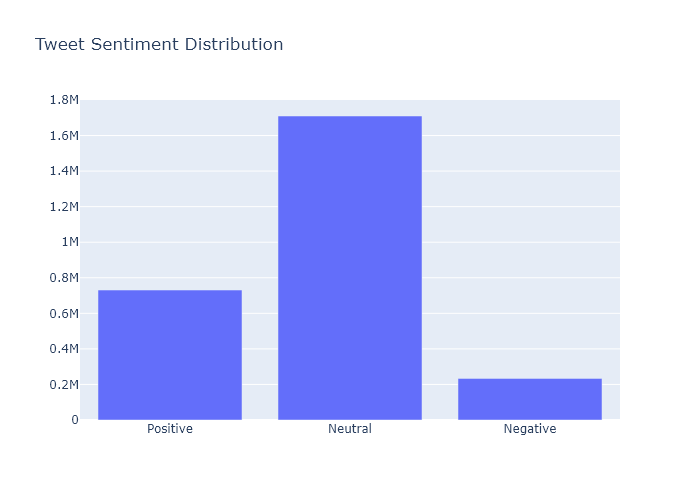

In [16]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(
    go.Bar(
        x = ['Positive', 'Neutral', 'Negative'],
        # Binary label
        y = df['label'].value_counts().sort_index()
        # One hot label
        # y = np.sum(df['label'].values)
    )
)

fig.update_layout(title_text = 'Tweet Sentiment Distribution')
fig.show()

The distribution is not balanced, we need to apply either downsampling and/or upsampling (augmentation) after this.

##### **Tweet Augmentation**
As you can see from the earlier graph, the tweet distribution is not balanced, so we need to augment some tweets to increase the data (especially the minority class). There are a few ready-made libraries we can use:
- `nlpaug`: Slower, but provide more authentic data (synonym/antonym, insert new word, etc)
- `imblearn`: Faster, but the augmented word may not represent real data (vector level augmentation, e.g. SMOTE)

Note that augmentation is a form of oversampling, since the data is already huge, we can also apply undersampling at the end of this section.

In [17]:
from nltk.corpus import stopwords
import nlpaug.augmenter.word as naw
import multiprocessing as mp

try:
    # Import the stopwords list
    # Very important, especially for antonym augmentation
    # Words like not, very, etc may have opposite effect if not ignored
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

# Don't reinitialize the augmenter on every function call
# "aug_p" is the percentage of words to be augmented
# "stopwords" will ignore specified words, but doesn't replace/remove them
aug_ant = naw.AntonymAug(aug_p = 0.8, stopwords = stop_words)
aug_syn = naw.SynonymAug(aug_src = 'wordnet', aug_p = 0.6, stopwords = stop_words)

# Replace words in a sentence with their synonym or antonym
# https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb
def preproc_augment(value: str, synonym = True):
    if synonym:
        # Augment will return a list, even if there is only 1 output
        value = aug_syn.augment(value, num_thread = mp.cpu_count())[0]
    else:
        # Note that for antonym, the augmenter doesn't replace emojis with their inverse variants
        # So we will need to remove emojis (and/or emoticons) after applying the antonym
        # https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python/
        value = aug_ant.augment(value, num_thread = mp.cpu_count())[0]
        value = value.encode('latin-1', 'ignore').decode('latin-1')

    return value

text = 'Your service is trully the worst!'
print('Original:', text)

print('Synonym:', preproc_augment(text))
print('Antonym:', preproc_augment(text, False))

Original: Your service is trully the worst!
Synonym: Your robert william service is trully the big!
Antonym: Your service is trully the unregretful!


Based on my observation, `nlpaug`'s built-in tokenizer will not lowercase words, it only use regex `\w` (alphabet + digit) match and then split it (check the `WordAugmenter` source code to see it).

If there is a stopword in a sentence that contains mixed/upper case (e.g. `It`, `IT`), it will still be processed (not ignored). In this case, the word may be replaced with `information technology` (which is wrong if the original sentence is `IT IS BAD!!!`). The side effect is not that severe in the case of sentiment analysis, but still need caution.

In [18]:
def label_equal(label, df):
    # The usual Pandas value query won't work if the data type is an array
    # It will assign the array to replace the whole column instead

    # Workaround to filter tweets belonging to a certain "label" (one hot array)
    # "label" is either positive (100), neutral (010), or negative (001)
    return df['label'].apply(lambda x:
        # One hot label
        np.array_equal(x, label)
        if type(x) == np.ndarray
        # Binary label
        else x == np.argmax(label)
    )

In [19]:
# Mark all members of the original dataframe as real data (not augmented)
df['augmented'] = False

if os.path.isfile('data/df_neg_1.csv'):
    # Load the saved augmented data if available
    df_neg_1 = pd.read_csv('data/df_neg_1.csv')
else:
    # Apply synonym augmentation to negative tweets (20-23 minutes)
    df_neg_1 = df[ label_equal(np.array([0, 0, 1]), df) ]
    df_neg_1['text'] = df_neg_1['text'].swifter.apply(preproc_augment)
    # Mark the augmented data
    df_neg_1['augmented'] = True

print(len(df_neg_1))
df_neg_1.head()

234006


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,label,augmented
0,8,115712,True,2017-10-31 21:45:10,is the bad client military service,[ 9 6 10],NaN,2,True
1,11,sprintcare,False,2017-10-31 22:10:35,This is sadden to take heed. Please sprout ame...,NaN,12.0,2,True
2,12,115713,True,2017-10-31 22:04:47,You gonna as if by magic convert your connecti...,[11 13 14],15.0,2,True
3,36,115719,True,2017-10-31 22:10:46,mortal from please assist me 😩 😩 😩 😩 1 ' m hav...,[34],NaN,2,True
4,57,115723,True,2017-10-31 19:58:22,Cut out every xx second this is derisory,[56],58.0,2,True


- Negative tweets (combined with the original) after the previous augmentation should be around 468k (234k * 2)
- It's still less than the positive tweets count (730k), so we need more augmentation (apply antonym to positive tweets)

In [20]:
if os.path.isfile('data/df_neg_2.csv'):
    # Load the saved augmented data if available
    df_neg_2 = pd.read_csv('data/df_neg_2.csv')
else:
    # How many positive tweets do we want to augment?
    n = 262000
    # Apply antonym augmentation to positive tweets (to help balance negative tweets count)
    # Note that not all positive tweets will become negative tweets even after augmentation
    df_neg_2 = df[ label_equal(np.array([1, 0, 0]), df) ].head(n)
    df_neg_2['text'] = df_neg_2['text'].swifter.apply(lambda x: preproc_augment(x, synonym = False))
    # Reapply VADER's sentiment analysis and mark the augmented data
    df_neg_2['label'] = df_neg_2['text'].swifter.apply(vader_sentiment)
    df_neg_2['augmented'] = True

    # Backup the unfiltered antonymized tweets
    print('Before filter:', len(df_neg_2))
    df_neg_2.to_csv('data/df_neg_2a.csv', index = False)
    # Take only the negative tweets
    df_neg_2 = df_neg_2 [ label_equal(np.array[0, 0, 1], df_neg_2) ]

print('After filter:', len(df_neg_2))
df_neg_2.head()

After filter: 30208


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,label,augmented
0,159,115736,True,2017-10-31 22:00:10,Btw starve out $ 3 burritos if you undress up ...,[158],NaN,2,True
1,316,115785,True,2017-11-01 01:13:10,Kinda obviate to unmake uncertain I have 680 $...,NaN,315.0,2,True
2,311,115785,True,2017-10-31 20:04:15,Would dislike to ignore so I can break uncerta...,[309],318.0,2,True
3,337,115797,True,2017-11-09 20:15:48,Hi! i would dislike to ignore on my itenerary ...,[338],335.0,2,True
4,369,115800,True,2017-10-31 14:25:55,You ' ll be even unhappy to ignore that the re...,[368 370],371.0,2,True


- From 262000 positive tweets, only 30208 ends up as negative tweets after applying the antonym augmentation. Combined with the previous synonym augmentation, we only end up with 264k new negative tweets (time needed: ~55 minutes)
- **Conclusion:** word based augmentation is slow and doesn't guarantee better class distribution, especially in the case of data balancing (oversampling). Next time, we should try vector level augmentation instead (SMOTE, etc)

In [21]:
def str_to_arr(value: str, dtype = None):
    if type(value) == float and math.isnan(value):
        return pd.NA
    else:
        # Take everything between square brackets (list)
        value = re.sub(r'\[([^]]+)\]', r'\1', value)
        # Convert space separated string to Numpy's array
        value = [ int(i) for i in value.split() ]
        return np.array(value, dtype)

def fix_data_type(df):
    df['label'] = df['label'].apply(lambda x: str_to_arr(x) if type(x) == str else int(x))
    df['response_tweet_id'] = df['response_tweet_id'].apply(lambda x: str_to_arr(x, np.int64))

    try:
        # https://strftime.org/
        df['created_at'] = pd.to_datetime(df['created_at'], format = '%Y-%m-%d %H:%M:%S+00:00')
    except ValueError:
        df['created_at'] = pd.to_datetime(df['created_at'], format = '%Y-%m-%d %H:%M:%S')

    # Convert float to Pandas' Int64 (support nan)
    # Pandas' Int64 array will use "pd.NA" rather than "np.nan"
    # https://pandas.pydata.org/docs/user_guide/integer_na.html
    cols = ['tweet_id', 'in_response_to_tweet_id']
    df[cols] = df[cols].astype('Int64')

    return df

# ======================

if not os.path.isfile('data/df_neg_1.csv'):
    # Save the augmented dataframe if it hasn't been saved yet
    df_neg_1.to_csv('data/df_neg_1.csv', index = False)
    df_neg_2.to_csv('data/df_neg_2.csv', index = False)
else:
    # If we load the saved augmented dataframe, fix the data type first
    df_neg_1 = fix_data_type(df_neg_1)
    df_neg_2 = fix_data_type(df_neg_2)

Backup the original data as `df_orig`, then decide whether to combine the augmented data with the original one or not.

In [22]:
df_orig = df.copy()

In [174]:
# Combine the augmented tweets with the original tweets
df = pd.concat([df_orig, df_neg_1, df_neg_2], ignore_index = True)

print(len(df))
df.head()

2939050


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,label,augmented
0,1,sprintcare,False,2017-10-31 22:10:47+00:00,I understand. I would like to assist you. We ...,[2],3,0,False
1,2,115712,True,2017-10-31 22:11:45+00:00,and how do you propose we do that,<NA>,1,1,False
2,3,115712,True,2017-10-31 22:08:27+00:00,I have sent several private messages and no o...,[1],4,1,False
3,4,sprintcare,False,2017-10-31 21:54:49+00:00,Please send us a Private Message so that we c...,[3],5,1,False
4,5,115712,True,2017-10-31 21:49:35+00:00,I did.,[4],6,1,False


See the tweets distribution after augmentation process.

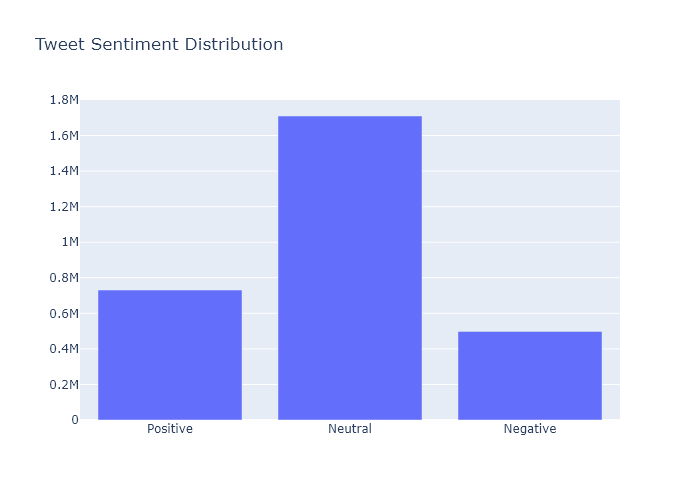

In [175]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(
    go.Bar(
        x = ['Positive', 'Neutral', 'Negative'],
        # Binary label
        y = df['label'].value_counts().sort_index()
        # One hot label
        # y = np.sum(df['label'].values)
    )
)

fig.update_layout(title_text = 'Tweet Sentiment Distribution')
fig.show()

The tweets are still not balanced, even though the number of negative tweets has now doubled (from 234k to 498k). To make the data more balanced, we can apply undersampling on the neutral tweets. Usually applying undersampling is discouraged since we may lose important features of the data. However, since the data we have is already too big (2.9 million tweets) and we don't use it for a research project, I think it doesn't hurt to apply undersampling, it will also make the training process a lot faster.

There are at least 3 types of undersampling:
- Stratified (proportionate) undersampling: Take fraction of data from each class proportionally (e.g. 1% of data from each class)
- Disproportionate undersampling: Take exactly the same amount of data from each class (e.g. 10000 data from each class)
- Random undersampling: Take N amount of data without grouping the data by class distribution (totally random)

In [176]:
# Set pseudo-random seed
seed = 1337
# Apply undersampling, or not
use_undersampling = True

In [177]:
if use_undersampling:
    # Apply stratified undersampling on the dataframe
    df = df.groupby('label', group_keys = False).apply(lambda x: x.sample(frac = 0.03, random_state = seed))

    # Apply disproportionate undersampling on the dataframe
    # df = df.groupby('label', group_keys = False).apply(lambda x: x.sample(n = 30000, random_state = seed))

    # The "sample" function is not truly random (always have the same class distribution)
    # "head" or "tail" can be used instead (will be trully random assuming the data is shuffled)
    # df = df.head(n = 90000)

print(df['label'].value_counts(normalize = True).mul(100))
print('Total rows:', len(df))

label
1    58.177859
0    24.869855
2    16.952286
Name: proportion, dtype: float64
Total rows: 88171


After applying oversampling/undersampling, ideally we should test whether the model loss curve is similar or not (compared to the unchanged dataset), see [this article](https://freedium.cfd/https://towardsdatascience.com/your-dataset-is-imbalanced-do-nothing-abf6a0049813) for some details. If the curve changed drastically, it means that we may have lose important features of the data.

#### **Basic Text Preprocessing (2)**
We need to apply additional preprocessing to reduce LSTM model complexity. Since tokenization will be applied later, things like punctuations, mixed string case, and other unexpected elements can be interpreted differently by the model if not normalized beforehand (e.g. `I'm`, `I am`, and `i am` are all different words).

However, if applied earlier, it can negatively affect VADER's accuracy, because VADER can also detect sentiment based on many factors, including string case and punctuations (`IT WAS SO FRUSTATING!!!`, etc).

We need to:
- Remove punctuations
- Convert text to lowercase
- Remove single character word
- Remove stopwords - **NOT USED**
- Apply stemming/lemmatization - **NOT USED**

In [178]:
# Stopwords we used when we did tweet augmentation earlier
print(stop_words)

{'you', 'his', "she's", 'once', 'they', 'from', 'him', 'again', 'under', 'but', 'then', 'been', "doesn't", 'itself', 't', 'more', 'yourself', 'off', "didn't", 'on', 'and', "should've", "needn't", 'ourselves', 'such', 'each', 'd', "hasn't", 'she', 'how', 'doesn', 'why', 'above', 'between', "weren't", 'needn', "shouldn't", 'is', 'nor', "haven't", 'didn', 'in', 'by', 'does', 've', "shan't", 'mightn', 'them', 'ma', 'weren', 'down', 'where', 'y', 'after', 'mustn', 'there', 'my', 'doing', 'were', 'aren', "hadn't", 'about', 'our', 'to', 'into', 'which', 'your', 'have', 'against', "mightn't", 'shouldn', 'wouldn', 'he', 'shan', 'being', 'too', 'haven', 'i', "isn't", 'those', 'through', 'o', 'who', 'so', 'having', 'yourselves', 'can', 'isn', 'her', 'own', 'same', "don't", 'further', 'when', 'herself', 's', 'during', 'theirs', 'are', 'm', 'for', 'here', 'few', "aren't", 'did', "you'd", "couldn't", 'couldn', 'hasn', "you'll", 'before', "wasn't", "wouldn't", 'myself', 'will', 'or', 'had', 'up', 'll

In [179]:
import string
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# =================================
# Stemmer or lemmatizer
# =================================

# Stemmer
porter = SnowballStemmer('porter')
snowball = SnowballStemmer('english')

# Lemmatizer
try:
    wordnet = WordNetLemmatizer()
except:
    nltk.download('wordnet')
    wordnet = WordNetLemmatizer()

# =================================
# LSTM preprocessing function
# =================================

def preproc_for_model(value: str, stemmer = None, stop_words = None):
    # Remove punctuations (and emoticons)
    value = re.sub(f'[{string.punctuation}]', ' ', value)
    # Lowercase, but ignore unicode characters
    value = value.casefold()
    # Remove 1-character word
    value = re.sub(r'\b[a-zA-Z]\b', '', value)
    # Replace multiple spaces with a single space
    value = re.sub(r'\s+', ' ', value)

    if stemmer or stop_words:
        # Split sentence as words (tokenization)
        word_token = value.split()

        if stop_words:
            # Remove stop words (must be prioritized before stemmer)
            word_token = [ word for word in word_token if word not in stop_words ]
        if stemmer:
            # Stem/lemmatize words
            try: word_token = [ stemmer.lemmatize(word) for word in word_token ]
            except: word_token = [ stemmer.stem(word) for word in word_token ]

        # Join the tokenized words again
        # A bit inefficient if we use it with TextVectorization layer
        value = ' '.join(word_token)
    
    return value

def preproc_all(value: str, stemmer = None):
    # Remove URLs, mentions, hashtags, etc
    value = preproc_useless_info(value)
    # Remove punctuations, stopwords, etc
    value = preproc_for_model(value, stemmer)
    return value

# =================================
# Test the preprocessing function
# =================================

text = 'Not good... I got the "Access Denied" error when opening the application 😤'
print('Original:', text, '\n')

print('Porter:', preproc_for_model(text, porter))
print('Snowball:', preproc_for_model(text, snowball))
print('WordNet:', preproc_for_model(text, wordnet))
print('Stopwords:', preproc_for_model(text, None, stop_words))
print('Default:', preproc_for_model(text))

Original: Not good... I got the "Access Denied" error when opening the application 😤 

Porter: not good got the access deni error when open the applic 😤
Snowball: not good got the access deni error when open the applic 😤
WordNet: not good got the access denied error when opening the application 😤
Stopwords: good got access denied error opening application 😤
Default: not good got the access denied error when opening the application 😤


- As you can see, the stemmer and lemmatizer didn't give good enough results, and similar words can also have slightly different meaning (like VADER scoring system). So, we can just skip it if we want to follow VADER's approach.

- As for stopwords removal, it doesn't give a good result either. By default, NLTK's stopwords will remove important features for sentiment analysis, such as `not`, `very`, `most`, etc, while the ones we need to remove are mostly conjunction/transition words (e.g. `although`, `with`, `that`). Unless we want to build our own stopwords list, then it's better to just skip it as it brings more harm than good.

The preprocessing will be done right before we apply tokenization/vectorization, so there's no need to apply it right now.

In [180]:
# df = df.swifter.apply(preproc_for_model)

### **LSTM Model Training**

#### **Split Training and Test Data**

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

def label_transformer(label_list: pd.Series, class_mode = 'binary'):
    if label_list.dtype == np.int64: # Already in binary
        if class_mode == 'one_hot':
            # Change array shape from [0 1 2 ...] to [[0] [1] [2] ...]
            label_list = np.reshape(label_list.values, (-1, 1))
            return OneHotEncoder(sparse = False).fit_transform(label_list)
        elif class_mode == 'binary':
            return label_list
    else: # Already one hot encoded
        # Fix nested array data type from (object,int) to (int,int)
        label_list =  np.stack(label_list.values)
        if class_mode == 'one_hot':
            return label_list
        elif class_mode == 'binary':
            return np.argmax(label_list, axis = 1)

# Label type (use one hot or binary)
# It depends on the model you want to design (sparse or categorical)
# Sparse model return probability, while categorical model return label
label = label_transformer(df['label'], 'binary')

# X is the data (text), while Y is the label (class)
x_train, x_test, y_train, y_test = train_test_split(
    df['text'],
    label,
    test_size = 0.2,
    # Distribute the data evenly
    stratify = label,
    # Seed for reproducibility
    random_state = seed
)

# Balance class weight to workaround imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)

In [182]:
class_weights = dict(zip(np.unique(y_train), class_weights))
print(class_weights)

{0: 1.3403260745639038, 1: 0.5729603275173019, 2: 1.9662150861348051}


In [183]:
print(len(x_train))
print(y_train.value_counts(normalize = True).mul(100))

70536
label
1    58.177385
0    24.869570
2    16.953045
Name: proportion, dtype: float64


In [184]:
print(len(x_test))
print(y_test.value_counts(normalize = True).mul(100))

17635
label
1    58.179756
0    24.870995
2    16.949249
Name: proportion, dtype: float64


#### **Defining Layers**

The terms `vector` and `array` are interchangeable.

- Tokenization: split sentence to words
- Vocabulary: list of known words (usually after tokenization process)
- Vectorization: transform the words to other form (one hot encoding, index based, TF-IDF, etc) based on a vocabulary

Note that when defining vocabulary size, 1-2 spaces will usually be reserved for OOV (out-of-vocabulary) and/or empty word. There are 2 at least to ways to do tokenization and vectorization:
- `Tokenizer` (function) will reserve 1 space
- `TextVectorization` (layer) will reserve 2 spaces

So you may want to add +1/+2 vocabulary size depending on what you want to use.

In [185]:
import keras

# Max words/features/vocabulary to save (most frequent words only)
# For comparison, the latest VADER (v3.3.2) has 11090 vocabulary (combined with emojis)
# We should at least match that if we want to compare it
max_vocab = 12000
# Max words for each sentence
# Sentence longer than that will be truncated
max_len = 50
# Indicator if you want to use Tokenizer on the model
# Otherwise, TextVectorization layer will be used
use_tokenizer = True
# Set seed for reproducibility
keras.utils.set_random_seed(seed)

There are many ways to convert words to vectors, you can either use:
- One Hot Encoding
- Count
- TF-IDF
- Word Index

The problem with one hot encoding is that each array size can be very big (since it's a binary array). For example, if there are 1000 rows (tweets) with 5000 vocab size, then it would produce 1000 arrays, each with 5000 length, which can be worse depending on the batch and data size (2.9 million tweets?).

That's why when using `Tokenizer`, `text_to_sequences` (int/word index based array) is preferred rather than `texts_to_matrix` (TF-IDF, one hot encoding, count, etc) nowadays.

We can also use `TextVectorization`, which does the same as `Tokenizer`, but can be integrated to the model directly (as preprocessing layer).

In [186]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

if use_tokenizer:
    # Apply preprocessing before tokenization (training only or both)
    x_train = x_train.swifter.apply(preproc_for_model)
    x_test = x_test.swifter.apply(preproc_for_model)

    # Add 1 vocabulary space for OOV (out-of-vocabulary) word
    max_vocab += 1

    # There's no empty token for one hot encoding (only OOV)
    # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
    tokenizer = Tokenizer(num_words = max_vocab, oov_token='[UNK]')

    # Build vocabulary based on texts (only the most frequent words will be saved)
    # Will generate word index (vocabulary), word index must match between training and test data
    tokenizer.fit_on_texts(x_train)
    # "text_to_sequences" will transform words to its index (like int mode in TextVectorization layer)
    # To transform words to other forms (TF-IDF, etc) use "texts_to_matrix" instead
    x_train = tokenizer.texts_to_sequences(x_train)

    # Don't use "fit_on_texts" on test data, because the word index (vocabulary) will be regenerated again
    # If the vocabulary between training and test data doesn't match, the model will have a bad accuracy
    # We only need to use "texts_to_sequences", any unknown word will be converted to OOV (index 1)
    x_test = tokenizer.texts_to_sequences(x_test)

    # Make sure all arrays have the same length (will follow the longest sentence if maxlen is not specified)
    # TextVectorization will use post-padding by default (uncustomizable), so we apply the same for reproducibility
    # Setting max length is optional, but by setting it, we can use a standardized model input shape
    # The length should be less/equal than the longest sentence, setting more will only increase memory usage
    x_train = pad_sequences(x_train, padding = 'post', truncating = 'post', maxlen = max_len) 
    x_test = pad_sequences(x_test, padding = 'post', truncating = 'post', maxlen = max_len)

    print('Vocabulary:', list(tokenizer.word_index)[:50])
    print('Vocabulary size:', len(tokenizer.word_index))
    print('Output vector:', x_train)
    print('Output vector size:', x_train.shape)

Pandas Apply:   0%|          | 0/70536 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/17635 [00:00<?, ?it/s]

Vocabulary: ['[UNK]', 'to', 'the', 'you', 'and', 'we', 'for', 'your', 'this', 'it', 'is', 'can', 'on', 'my', 'in', 'with', 'us', 'of', 'have', 'please', 'that', 'dm', 'be', 'so', 'me', 'not', 'are', 'help', 'if', 'our', 'at', 'hi', 'no', 'but', 'what', 'out', 'there', 'get', 'here', 'sorry', 'thanks', 'do', 're', 'was', 'from', 'will', '2', 'as', 'up', 'just']
Vocabulary size: 34209
Output vector: [[ 32  37 156 ...   0   0   0]
 [ 21 527  62 ...   0   0   0]
 [346 151  13 ...   0   0   0]
 ...
 [ 15   3 778 ...   0   0   0]
 [107  10 109 ...   0   0   0]
 [ 10  67 228 ...   0   0   0]]
Output vector size: (70536, 50)


In [212]:
import tensorflow as tf

# Encoding to interpret the text (to be passed to the model)
# Some encodings can remove "unique" characters such as emojis (e.g. latin-1)
encoding = 'utf-8'

# This is a hacky function to automate text preprocessing as part of the model
# There is no need to apply preprocessing separately (unless you use Tokenizer)
def custom_standardization(input_data):
    # Skip if the layer is just initialized (no data yet)
    if tf.is_symbolic_tensor(input_data): return input_data

    # Convert tensor to Numpy's array (for easier manipulation)
    # The array will have byte as it's data type
    input_data = input_data.numpy()

    """ # TODO Apply vectorization
    for i in range(len(input_data)):
        # Apply preprocessing
        # Convect byte to string and vice versa
        input_data[i] = bytes(
            preproc_for_model(input_data[i].decode('utf-8')),
            'utf-8'
        ) """

    __preproc_for_model = np.vectorize(
        lambda sentence: bytes(
            # Please change to "preproc_all" instead for unseen data
            # Since we did sentiment analysis earlier, "preproc_useless_info" is already applied
            # So all that's left is to apply "preproc_for_model" (remove punctuations, etc)
            preproc_for_model(sentence.decode(encoding)),
            encoding
        ),
        cache = True
    )

    # Appply preprocessing and convert back Numpy's byte array to tensor
    input_data = __preproc_for_model(input_data)
    input_data = tf.convert_to_tensor(input_data)

    return input_data

In [220]:
# 2 spaces will be reserved to for empty word and OOV (out-of-vocabulary)
# Unlike Tokenizer which only take 1 vocabulary space (OOV only)
if not use_tokenizer: max_vocab += 2

# Based on the docs, Tokenizer is already deprecated, use TextVectorization instead
# TextVectorization can integrate preprocessing (standardization) function such as part of the layer
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
# https://www.tensorflow.org/guide/keras/preprocessing_layers
vectorization_layer = keras.layers.TextVectorization(
    # Low vocabulary may affect accuracy, while high vocabulary can affect complexity & memory usage
    max_tokens = max_vocab,
    # "lower_and_strip_punctuation", "lower", "strip_punctuation", None, or custom function
    # FIXME Currently, the custom function won't affect the vocabulary list (lowercase won't be applied, etc)
    standardize = custom_standardization,
    # Use 2 or higher to possibly detect idioms, negation, slang words, etc
    # None means no N-grams when splitting words aka 1-gram
    ngrams = None,
    # Either "int" (index array), "multi_hot" (0/1 array), "count" (count array), or "tf_idf" (ratio array)
    # Use "int" to minimize array size, but may be a burden for computation later (e.g. multiplication)
    output_mode = 'int',
    # Apply post-padding (all zeros) to each array up to max tokens, ignored if using "int" mode
    # Warning: will consume a large amount of memory if the vocabulary list is huge
    # Regardless it's used or not, all arrays will always have uniform length
    pad_to_max_tokens = False,
    # Limit or set array size for each sample, only applies to "int" mode
    # Useful to further reduce memory usage and limit garbage words, but can affect accuracy
    # If the array size is less than the specified length, post-padding will be applied
    # And if it is bigger than embedding input size, truncation will be applied
    output_sequence_length = False,
    # Encoding to interpret the text
    # Some encodings can remove "unique" characters such as emojis (e.g. latin-1)
    encoding = encoding,
    # Layer name (optional)
    name = 'text_vectorization'
)

text = [
    'Your company is the best, especially the service you provided 🤩',
    'The customer service is so-so, not good but not bad either',
    'The service is NOT GOOD at all, the guy I contacted is so rude!!!'
]

# Experiment with the hyperparameters above, then test the result
vectorization_layer.adapt(text)

print('Vocabulary:', vectorization_layer.get_vocabulary()[:50])
print('Vocabulary size:', vectorization_layer.vocabulary_size())
print('Output vector:', vectorization_layer(text))

Vocabulary: ['', '[UNK]', 'is', 'the', 'service', 'not', 'The', '🤩', 'you', 'so-so,', 'so', 'rude!!!', 'provided', 'guy', 'good', 'especially', 'either', 'customer', 'contacted', 'company', 'but', 'best,', 'bad', 'at', 'all,', 'Your', 'NOT', 'I', 'GOOD']
Vocabulary size: 29
Output vector: tf.Tensor(
[[ 1 19  2  3  1 15  3  4  8 12  7  0  0]
 [ 3 17  4  2 10 10  5 14 20  5 22 16  0]
 [ 3  4  2  5 14 23  1  3 13 18  2 10  1]], shape=(3, 13), dtype=int64)

Note: Currently, the custom standardization function won't affect the vocabulary list (lowercase won't be applied, etc). I have filled an issue here: [#62653](https://github.com/tensorflow/tensorflow/issues/62653). In the meantime, we will use `Tokenizer` function instead of the `TextVectorization` layer.

In [189]:
if not use_tokenizer:
    # Rebuild the vocabulary using the whole training data (no need to adapt the test data)
    # If the vocabulary between training and test data is different, the model will be confused
    vectorization_layer.adapt(x_train)
    print(vectorization_layer.get_vocabulary()[:50])
    print(vectorization_layer.vocabulary_size())

In [190]:
# Reset Keras layers/models to their initial state
keras.backend.clear_session()

# Set model input shape
if use_tokenizer:
    # Sentences already vectorized
    input_shape = (max_len,)
    input_dtype = tf.int64
else:
    # Still just sentences
    input_shape = (1,)
    input_dtype = tf.string

# https://keras.io/examples/nlp/text_classification_from_scratch
model = keras.models.Sequential([
    keras.layers.Input(shape = input_shape, dtype = input_dtype),

    # TODO Make a custom layer subclass instead of using lambda
    # keras.layers.Lambda(custom_standardization),
    keras.layers.Lambda(lambda x: x if use_tokenizer else vectorization_layer(x)),
    # vectorization_layer,

    # Truncation may be applied if the array size is longer than input length
    keras.layers.Embedding(input_dim = max_vocab, output_dim = 50, input_length = max_len),

    keras.layers.Conv1D(filters = 32, kernel_size = 1, padding = 'same', activation = 'relu'),
    keras.layers.MaxPooling1D(pool_size = 2),

    # If the result is still bad with dropout we can also use regularizer or batch normalization
    # https://stats.stackexchange.com/questions/383310/difference-between-kernel-bias-and-activity-regularizers
    # https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1L2
    keras.layers.Bidirectional(keras.layers.LSTM(units = 32, kernel_regularizer = 'l1_l2')),
    keras.layers.Dropout(rate = 0.4),

    keras.layers.Dense(units = 128, activation = 'relu'),
    keras.layers.Dense(units = 64, activation = 'relu'),

    # Positive, neutral, or negative sentiment (3 classes)
    keras.layers.Dense(units = 3, activation = 'softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 50)                0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            600050    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            1632      
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0

#### **Begin Model Training**

In [191]:
import json

# Encoder to save model training history
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        # Some Numpy objects can't be encoded to json directly
        if isinstance(obj, np.ndarray): return obj.tolist()
        elif isinstance(obj, np.float32): return float(obj)
        return super().default(self, obj)

class StopAtAcc(tf.keras.callbacks.Callback):
    def __init__(self, threshold: int):
        super(StopAtAcc, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs: dict): 
        acc = logs.get('acc')
        val_acc = logs.get('val_acc')

        if acc >= self.threshold and val_acc >= self.threshold:
            print(f'Epoch {epoch}: Reached {acc}% acc and {val_acc}% val_acc, stopping training')
            self.model.stop_training = True

# =======================
# Callback Function
# =======================

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    # Don't save as keras if using the lambda layer
    filepath = f'misc/model.tf',
    monitor = 'val_acc',
    mode = 'max',
    save_best_only = True,
    save_weights_only = False,
    verbose = 1
)

# Data must be shuffled if you want to use early stopping
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_acc',
    min_delta = 0,
    patience = 10,
    mode = 'max',
    restore_best_weights = True,
    verbose = 1
)

stop_at = StopAtAcc(threshold = 90)

# =======================
# Training Model
# =======================

model.compile(
    optimizer = keras.optimizers.AdamW(),
    # Change loss depending on the label type (one hot/binary) and preferred output (probability/label)
    # Sparse categorical = probability (e.g. [0.5 0.3 0.2]), categorical = label (e.g. [1 0 0])
    # Use "from_logits = False" if the output is already normalized (e.g. using softmax)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = [ keras.metrics.SparseCategoricalAccuracy(name = 'acc') ]
)

# Try to load existing model first
if os.path.isfile(f'misc/model.hist'):
    is_training = False
    model = keras.models.load_model(f'misc/model.tf')
    with open(f'misc/model.hist') as hist:
        history = json.load(hist)
else:
    is_training = True
    # Train model from beginning
    train = model.fit(
        x_train,
        y_train,
        epochs = 50,
        validation_data = (x_test, y_test),
        # Give more weight to class with less members
        class_weight = class_weights,
        # Model will be saved via checkpoint callbacks
        callbacks = [ checkpoint, early_stopping, stop_at ],
        verbose = 1
    )
    # Restore the best model from training (not always the last epoch)
    model = keras.models.load_model(f'misc/model.tf')
    # Save the model training history
    with open(f'misc/model.hist', 'w') as hist:
        json.dump(train.history, hist, cls = NumpyEncoder)
    history = train.history

Epoch 1/50
2205/2205 [==============================] - ETA: 0s - loss: 0.8444 - acc: 0.7408
Epoch 1: val_acc improved from -inf to 0.82104, saving model to misc\model.tf
INFO:tensorflow:Assets written to: misc\model.tf\assets


INFO:tensorflow:Assets written to: misc\model.tf\assets


2205/2205 [==============================] - 127s 55ms/step - loss: 0.8444 - acc: 0.7408 - val_loss: 0.4823 - val_acc: 0.8210
Epoch 2/50
2205/2205 [==============================] - ETA: 0s - loss: 0.3980 - acc: 0.8398
Epoch 2: val_acc improved from 0.82104 to 0.82217, saving model to misc\model.tf
INFO:tensorflow:Assets written to: misc\model.tf\assets


INFO:tensorflow:Assets written to: misc\model.tf\assets


2205/2205 [==============================] - 238s 108ms/step - loss: 0.3980 - acc: 0.8398 - val_loss: 0.4722 - val_acc: 0.8222
Epoch 3/50
2204/2205 [============================>.] - ETA: 0s - loss: 0.3600 - acc: 0.8591
Epoch 3: val_acc improved from 0.82217 to 0.85143, saving model to misc\model.tf
INFO:tensorflow:Assets written to: misc\model.tf\assets


INFO:tensorflow:Assets written to: misc\model.tf\assets


2205/2205 [==============================] - 164s 74ms/step - loss: 0.3599 - acc: 0.8591 - val_loss: 0.4200 - val_acc: 0.8514
Epoch 4/50
2205/2205 [==============================] - ETA: 0s - loss: 0.3368 - acc: 0.8688
Epoch 4: val_acc improved from 0.85143 to 0.85620, saving model to misc\model.tf
INFO:tensorflow:Assets written to: misc\model.tf\assets


INFO:tensorflow:Assets written to: misc\model.tf\assets


2205/2205 [==============================] - 167s 76ms/step - loss: 0.3368 - acc: 0.8688 - val_loss: 0.4046 - val_acc: 0.8562
Epoch 5/50
2204/2205 [============================>.] - ETA: 0s - loss: 0.3207 - acc: 0.8764
Epoch 5: val_acc improved from 0.85620 to 0.86243, saving model to misc\model.tf
INFO:tensorflow:Assets written to: misc\model.tf\assets


INFO:tensorflow:Assets written to: misc\model.tf\assets


2205/2205 [==============================] - 160s 73ms/step - loss: 0.3207 - acc: 0.8764 - val_loss: 0.3940 - val_acc: 0.8624
Epoch 6/50
2205/2205 [==============================] - ETA: 0s - loss: 0.3062 - acc: 0.8825
Epoch 6: val_acc did not improve from 0.86243
2205/2205 [==============================] - 159s 72ms/step - loss: 0.3062 - acc: 0.8825 - val_loss: 0.4170 - val_acc: 0.8517
Epoch 7/50
2204/2205 [============================>.] - ETA: 0s - loss: 0.2945 - acc: 0.8876
Epoch 7: val_acc improved from 0.86243 to 0.86799, saving model to misc\model.tf
INFO:tensorflow:Assets written to: misc\model.tf\assets


INFO:tensorflow:Assets written to: misc\model.tf\assets


2205/2205 [==============================] - 176s 80ms/step - loss: 0.2945 - acc: 0.8876 - val_loss: 0.3858 - val_acc: 0.8680
Epoch 8/50
2204/2205 [============================>.] - ETA: 0s - loss: 0.2847 - acc: 0.8922
Epoch 8: val_acc did not improve from 0.86799
2205/2205 [==============================] - 140s 63ms/step - loss: 0.2848 - acc: 0.8922 - val_loss: 0.4016 - val_acc: 0.8577
Epoch 9/50
2204/2205 [============================>.] - ETA: 0s - loss: 0.2747 - acc: 0.8956
Epoch 9: val_acc did not improve from 0.86799
2205/2205 [==============================] - 140s 63ms/step - loss: 0.2748 - acc: 0.8956 - val_loss: 0.3958 - val_acc: 0.8659
Epoch 10/50
2204/2205 [============================>.] - ETA: 0s - loss: 0.2661 - acc: 0.8983
Epoch 10: val_acc did not improve from 0.86799
2205/2205 [==============================] - 146s 66ms/step - loss: 0.2661 - acc: 0.8983 - val_loss: 0.4133 - val_acc: 0.8555
Epoch 11/50
2205/2205 [==============================] - ETA: 0s - loss: 0.26

Note that only model with the best `val_acc` will be saved and used, so the last epoch is just an indicator when the training stop.

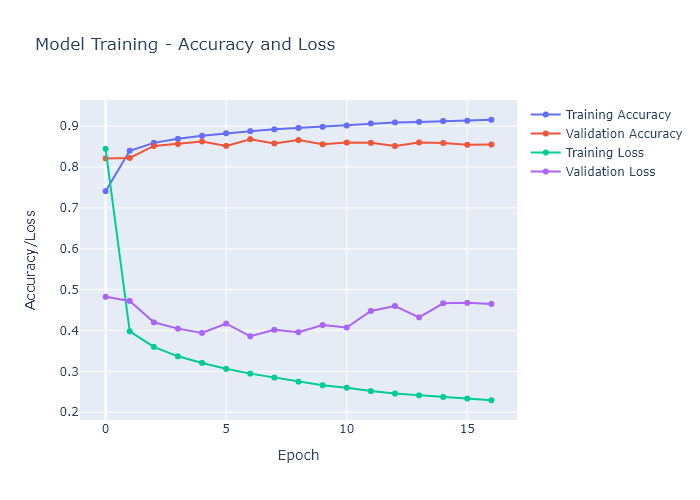

In [192]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = [ i for i in range(len(history['acc'])) ],
        y = history['acc'],
        name = 'Training Accuracy'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i for i in range(len(history['acc'])) ],
        y = history['val_acc'],
        name = 'Validation Accuracy'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i for i in range(len(history['acc'])) ],
        y = history['loss'],
        name = 'Training Loss'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i for i in range(len(history['acc'])) ],
        y = history['val_loss'],
        name = 'Validation Loss'
    )
)

fig.update_traces(mode = 'markers+lines')

fig.update_layout(
    # https://plotly.com/python/reference/layout/
    title = { 'text': 'Model Training - Accuracy and Loss' },
    # https://plotly.com/python/reference/layout/xaxis/
    xaxis = { 'title': 'Epoch' },
    # https://plotly.com/python/reference/layout/yaxis/
    yaxis = { 'title': 'Accuracy/Loss' },
    hovermode = 'x unified',
    hoverlabel = { 'namelength': -1 }
)

fig.show()

Stopped at epoch 17, but the best `val_acc` is at epoch 7, so model from epoch 7 will be used instead.

In [197]:
def predict_tweets(tweets: list):
    if use_tokenizer:
        # "preproc_all" = "preproc_useless_info" + "preproc_for_model"
        tweets = [ preproc_all(i) for i in tweets ]

        # Convert sentences to vector
        tweets = tokenizer.texts_to_sequences(tweets)
        tweets = pad_sequences(tweets, padding = 'post', truncating = 'post', maxlen = max_len)
    else:
        # "preproc_for_model" will be called by TextVectorization layer
        tweets = [ preproc_useless_info(i) for i in tweets ]

    return model.predict(tweets)

def sparse_to_label(array: np.ndarray):
    i = array.argmax()
    return ['Positive', 'Neutral', 'Negative'][i]

text = [
    'Your customer service is awful',
    'Your customer service is awful 👿',
    'Your customer service is ok',
    'Your customer service is good',
    'Your customer service is good 😊'
]

with np.printoptions(precision = 5, suppress = True):
    result = predict_tweets(text)
    for i in range(len(result)):
        print(f'{text[i]}')
        print(f'LSTM -> {result[i]} {sparse_to_label(result[i])}')
        print(f'VADER -> {vader_sentiment(text[i], "label")}', '\n')

1/1 [==============================] - 0s 66ms/step
Your customer service is awful
LSTM -> [0.00861 0.38315 0.60824] Negative
VADER -> Neutral 

Your customer service is awful 👿
LSTM -> [0.00864 0.36702 0.62434] Negative
VADER -> Negative 

Your customer service is ok
LSTM -> [0.04808 0.9392  0.01271] Neutral
VADER -> Neutral 

Your customer service is good
LSTM -> [0.22569 0.65428 0.12003] Neutral
VADER -> Neutral 

Your customer service is good 😊
LSTM -> [0.98203 0.0172  0.00077] Positive
VADER -> Positive 



Even though the model's training accuracy is not good (less than 90% accuracy), it can still predict tweet sentiment correctly (using words and emojis). Therefore, I can conclude that this model is good enough.

### **Changelog**

- v1: Vectorization 5000 vocab size, embedding 32 output dims & 50 input length, Conv1D 32 filters, LSTM 32 units, dropout 0.4, dense 128, dense 64. Trained with 14 epoch resulting 60% accuracy using stratified undersampling 0.1 frac. Callback reduce LR 3, early stop 6
- v2: Added max pool layer with pool size = 2 after Conv1D. Stopped manually at 7 epoch with accuracy 60%
- v3: Switched to Bi-LSTM, increased vocab size to 20000. Stopped manually at 7 epoch with accuracy 60%. Sample size reduced to 0.01
- v4: Bi-LSTM 64, batch size changed to 128 (the default is 32). Early stop at 23 epoch with 60% accuracy
- v5: Using original data only (not combined with augmented data). Early stop at epoch 15 with 64% accuracy (slightly increased)
- v6: Changed to disproportionate undersampling with N = 15000. Accuracy decreased to 50%, early stop at epoch 23.
- v7: Switched to normal LSTM (not Bi-LSTM), with 9000 vocab size. Re-adapt text with training data (turns out vectorization layer doesn't automatically readapt when begining training). Accuracy improved to 81%, early stop at epoch 9. Graph overfit
- v8: Stratified undersampling 0.02 (~58000 data). Reduce LR increased to 5 and early stop at 10, vocab size 12000. Still overfit training
- v9: Stratified undersampling 0.03 (~88000 data). Manual stop at epoch 9, vocab size 12000. Still overfit
- v10: Stratified undersampling 0.03 (~88000 data). Manual stop at epoch 9, vocab size 21000. Still overfit
- v11: Disproportionate undersampling 30000 (90000 data). Manual stop at epoch 9, vocab size 21000. Still overfit
- v12: Switch to Tokenizer instead of TextVectorization layer, since the preprocessing wasn't applied correctly. Used Bi-LSTM again. Early stop at epoch 13. Still overfit
- v13: Reduced LSTM units to 32 for faster training. Used class weight balancing and stratified undersampling. Changed optimizer from Adam to AdamW

### **Todo**

- Inspect the output of each model layer like CNN
- Reduce overfit without increasing sample size (switch embedding with TF-IDF? use pretrained embedding?) - [Reference](https://medium.com/@dcameronsteinke/tf-idf-vs-word-embedding-a-comparison-and-code-tutorial-5ba341379ab0)
- EDA (the worst customer service, wordcloud, etc)